# Fase 4: Modelamiento predictivo
El objetivo de esta etapa es generar un modelo predictivo utilizando técnicas de machine learning que permita dar respuesta a la necesidad planteada de crear un estimador de precios de vehículos de segunda mano

Se han llevado a cabo las siguientes tareas:
- Creación de subconjuntos de entrenamiento y prueba
- Transformación logarítmica del vector objetivo
- Estandarización
- Modelación predictiva
    - Entrenamiento sobre los datos con imputación de valores perdidos 
    - Entrenamiento sobre los datos con eliminación de valores perdidos
    - Generación de predicciones y análisis de métricas
    - Análisis de coeficientes / importancias de los modelos entrenados
- Serialización del modelo ganador, su escalador y sus columnas de entrenamiento para la puesta en producción

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
import pickle



import ancillary_funcs as aux

import warnings
warnings.simplefilter('ignore')

## Importación de los subconjuntos de entrenamiento y prueba

In [2]:
# Dataset perteneciente a los datos faltantes imputados
df_imp = pd.read_csv('df_imp.csv')

## Creación de subconjuntos de entrenamiento y prueba

- Para la division de muestras del dataset vamos a utilizar el método train_test_split procedente del módulo model_selection de la librería scikit-learn que nos permite la division de los datos en subconjuntos de entrenamiento y prueba. 
- Preservaremos en los subconjuntos de prueba un 33% de los datos (test_size) y declararemos una semilla pseudoaleatoria que permita replicar la muestra (random_seed).
- No vamos a crear un tercer subconjunto hold-out sample puesto que no vamos a entrenar con hiperparámetros

In [3]:
# Separamos el vector objetivo de la matriz de atributos independientes para el dataset de valores perdidos imputados
X_mat_imp = df_imp.drop(columns='price')
y_vec_imp = df_imp['price']

In [4]:
# Separamos la matriz de atributos independientes imp en subconjuntos de entrenamiento y prueba
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_mat_imp, y_vec_imp, test_size=.33, random_state=1312)

## Transformación logarítmica del vector objetivo
Efectuamos la transformación logarítmica del vector objetivo por las siguientes razones:

- Estabiliza la varianza: La transformación logarítmica puede ayudar a reducir la heterocedasticidad (presencia de una varianza no constante en los errores del modelo), lo que mejora el cumplimiento de los supuestos de homogeneidad de varianza en el análisis estadístico.

- Aproxima una distribución normal: Si el vector objetivo sigue una distribución sesgada, la transformación logarítmica puede acercar los datos a una distribución más simétrica y normal, lo que facilita el análisis estadístico.

- Mitiga el impacto de valores atípicos: La transformación logarítmica puede disminuir la influencia de valores atípicos o extremos, lo que ayuda a obtener estimaciones más robustas y reducir su impacto en el análisis.

- Mejora la linealidad: En modelos lineales y no lineales, la transformación logarítmica puede ayudar a lograr una relación más lineal entre las variables independientes y el vector objetivo, mejorando el ajuste y la interpretación del modelo.

In [5]:
# Transformación logarítmica
y_train_imp_log = np.log(y_train_imp)
y_test_imp_log = np.log(y_test_imp)

In [6]:
# Comprobamos como es la distribución del vector objetivo después de la transformación
y_vec_imp_log = pd.concat([y_test_imp_log, y_train_imp_log], axis=0)

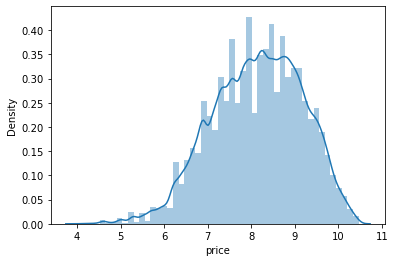

In [7]:
sns.distplot(y_vec_imp_log);

- Se observa como la distribución del vector objetivo pasó de una fuerte asimetría y sesgo a la derecha a una distribución más aproximada a la normal con un ligero sesgo a la izquierda.
- Debemos tener en cuenta que esta transformación tendrá que ser revertida a la hora de generar las predicciónes y analizar las métricas

## Estandarización
- La diferencia en la escala de valores de las variables continuas (año de registro, potencia y kilómetros) nos conduce a estandarizarlas.

- Vamos a estandarizar los atributos  excluyendo de la operación las variables binarias. 
- Llevamos a cabo el entrenamiento (.fit) y transformación (.transform) en dos pasos diferenciados y solo sobre los subconjuntos de entrenamiento y no en todo el dataframe para evitar la fuga de datos o data leakage, es decir, el uso de información del subconjunto de prueba en el entrenamiento del modelo.

In [8]:
X_train_std_imp, X_test_std_imp, scaler_imp = aux.estandarizacion(['yearOfRegistration', 'powerPS', 'kilometer'],
                                                              X_train_imp,
                                                              X_test_imp)

## Modelación predictiva (primera iteración)

### Modelos predictivos utilizados
**LinearRegression**:
- Funcionamiento: Modelo de regresión lineal que encuentra la mejor línea recta que se ajusta a los datos minimizando la suma de los errores cuadrados.
- Ventajas: Fácil interpretación, rápido entrenamiento y adecuado para problemas con relaciones lineales entre variables.
- Limitaciones: Limitado para problemas con relaciones no lineales y puede ser sensible a valores atípicos.

**DecisionTreeRegressor**:

- Funcionamiento: Modelo de árbol de decisión que divide el espacio de características en subconjuntos más pequeños mediante reglas de decisión para hacer predicciones.
- Ventajas: Capacidad para aprender relaciones no lineales y adaptarse a diferentes escalas de características.
- Limitaciones: Propenso al sobreajuste y puede ser difícil de interpretar en árboles grandes y profundos.

**RandomForestRegressor**:

- Funcionamiento: Conjunto de árboles de decisión (Random Forest) que promedia las predicciones de varios árboles para mejorar la precisión y reducir el sobreajuste.
- Ventajas: Mejora la generalización en comparación con un solo árbol, maneja características no lineales y es menos propenso al sobreajuste.
- Limitaciones: Menos interpretable que un árbol de decisión único y puede requerir más tiempo de entrenamiento que un solo árbol.

**XGBRegressor**:

- Funcionamiento: Implementación de Extreme Gradient Boosting (XGBoost) para regresión, que utiliza un conjunto de árboles de decisión mejorados mediante técnicas de regularización.
- Ventajas: Alta precisión y eficiencia, manejo de características no lineales y características de importancia incorporadas.
- Limitaciones: Configuración de hiperparámetros crítica para obtener el mejor rendimiento.

In [9]:
#pip install xgboost

In [10]:
# Definimos una semilla pseudoaleatoria
seed=1234

# Instanciamos los modelos
model_lr = LinearRegression()
model_DT = DecisionTreeRegressor(random_state=seed)
model_RF = RandomForestRegressor(random_state=seed)
model_XGB = XGBRegressor()

In [11]:
# Establecemos una lista iterable con los modelos instanciados
lista_modelos_vanilla = [model_lr, 
                         model_DT, 
                         model_RF,
                         model_XGB,
                        ]

### Entrenamiento sobre los datos con imputación de valores perdidos
- Se van a comentar las líneas del entrenamiento para evitar volver a reentrenar cada vez que se ejecute el script.

In [12]:
#%%time
#for model in lista_modelos_vanilla:
#    print(f'Modelo: {model}')
#    tmp_modelo_entrenado = aux.entrenamiento_modelo_vanilla(model, X_train_std_imp, y_train_imp_log)
#    aux.serializar_modelos(tmp_modelo_entrenado, 'it1_imp')
#    print('-'*120)
#    print(' ')

### Generación de predicciones y análisis de métricas

#### Definición de métricas
Utilizaremos las siguientes métricas para medir el desempeño de nuestros modelos:

**R2**
- El coeficiente de determinación, también conocido como R2 (R-cuadrado), es una métrica que se utiliza para evaluar la calidad de un modelo de regresión. Proporciona una medida de qué tan bien se ajustan los valores pronosticados por el modelo a los valores reales de la variable objetivo. El R2 varía entre 0 y 1, donde 1 indica un ajuste perfecto del modelo y 0 indica que el modelo no ofrece una mejora respecto a la predicción por la media.

- El R2 representa la proporción de varianza explicada por el modelo en relación con la varianza total de los datos. Por lo tanto, una interpretación del R2 podría ser que un valor del 0.8 significa que el modelo puede explicar el 80% de la variabilidad de la variable objetivo mientras que el otro 20% se debe a factores no considerados por el modelo.

**RMSE**
- El RMSE (Root Mean Squared Error) es una métrica utilizada para medir la precisión promedio de un modelo de regresión al predecir valores continuos. Se calcula como la raíz cuadrada del error cuadrático medio (MSE), lo que significa que penaliza los errores más grandes de manera más significativa que los errores más pequeños. El RMSE tiene la misma unidad que la variable objetivo y proporciona una medida de dispersión promedio entre las predicciones y los valores reales.
- Representa la desviación estándar promedio de las predicciones del modelo con respecto a los valores reales. Cuanto más bajo sea el valor del RMSE, mejor será la precisión del modelo, ya que indicará una menor dispersión entre las predicciones y los valores reales. Un RMSE de 5.5 por ejemplo, indica que las predicciones del modelo difieren de los valores reales en aproximadamente 5.5 unidades. 
- Se debe tener en cuenta que solo proporciona información sobre la precisión promedio del modelo y no brinda información sobre la dirección o el sesgo de los errores. Además, el RMSE puede ser sensible a los valores atípicos en los datos, ya que penaliza los errores cuadráticos.

**MAE**
- El MAE (Mean Absolute Error) es una métrica utilizada para medir la magnitud promedio de los errores en un modelo de regresión. Se calcula como la media de las diferencias absolutas entre las predicciones del modelo y los valores reales. El MAE es una medida de la precisión promedio del modelo y tiene la misma unidad que la variable objetivo. Tiene la ventaja de ser simple y fácil de interpretar. 
- Un MAE de 3, por ejemplo; quiere decir que, en promedio, las predicciones del modelo difieren de los valores reales en aproximadamente 3 unidades. Cuanto más cercano a cero sea el MAE, mejor será la precisión del modelo y más cercanas serán las predicciones a los valores reales.
- El RMSE es más sensible a los errores grandes, mientras que el MAE trata todos los errores por igual. 

**MAPE**
- El MAPE (Mean Absolute Percentage Error) es una métrica utilizada para evaluar el rendimiento de un modelo de regresión en términos de porcentaje de error relativo promedio. Se calcula como el promedio de los valores absolutos de los porcentajes de error entre las predicciones del modelo y los valores reales, dividido por el valor real y multiplicado por 100.
- Representa el error promedio como un porcentaje del valor real. Cuanto menor sea el valor del MAPE, mejor será la precisión del modelo, ya que indicará un menor porcentaje de error relativo promedio.
- Se considera útil para capturar la precisión en diferentes partes del rango de valores debido a su naturaleza relativa. A diferencia de otras métricas, el MAPE se expresa como un porcentaje y no en la unidad de medida de la variable objetivo. Esto permite que la métrica sea comparable y comprensible en diferentes escalas y rangos de valores.
- Por ejemplo, un MAPE de 5% significa que, en promedio, las predicciones del modelo difieren en un 5% del valor real.

#### Métricas para los modelos de los datos con imputación de valores perdidos

In [13]:
df_results_it1_imp_train = pd.DataFrame({'lr': aux.predicciones_metricas('LinearRegression_it1_imp.pkl', X_train_std_imp, y_train_imp_log),
                                         'dt': aux.predicciones_metricas('DecisionTreeRegressor_it1_imp.pkl', X_train_std_imp, y_train_imp_log),
                                         'rf': aux.predicciones_metricas('RandomForestRegressor_it1_imp.pkl', X_train_std_imp, y_train_imp_log),
                                         'xgb': aux.predicciones_metricas('XGBRegressor_it1_imp.pkl', X_train_std_imp, y_train_imp_log)
                                 }, index = ['r2', 'rmse', 'mae', 'mape'])

In [14]:
df_results_it1_imp_test = pd.DataFrame({'lr': aux.predicciones_metricas('LinearRegression_it1_imp.pkl', X_test_std_imp, y_test_imp_log),
                                        'dt': aux.predicciones_metricas('DecisionTreeRegressor_it1_imp.pkl', X_test_std_imp, y_test_imp_log),
                                        'rf': aux.predicciones_metricas('RandomForestRegressor_it1_imp.pkl', X_test_std_imp, y_test_imp_log),
                                        'xgb': aux.predicciones_metricas('XGBRegressor_it1_imp.pkl', X_test_std_imp, y_test_imp_log)
                                 }, index = ['r2', 'rmse', 'mae', 'mape'])

In [15]:
print('Modelos entrenados sobre los datos con imputación de valores perdidos')
print('Rendimiento sobre los datos de entrenamiento')
df_results_it1_imp_train

Modelos entrenados sobre los datos con imputación de valores perdidos
Rendimiento sobre los datos de entrenamiento


,lr,dt,rf,xgb
r2,0.81,0.98,0.97,0.90
rmse,2340.79,812.58,981.37,1687.47
mae,717.05,19.82,301.12,596.05
mape,0.37,0.12,0.16,0.30


- Los R2 obtenidos sobre los datos de entrenamiento son elevados para todos los modelos, excesivamente para los modelos Decision TreeRegressor, RandomForest y quizá también XGBRegressor. Esto indicaría que estos últimos modelos aprendieron los datos 'de memoria', al ajustarse demasiado bien a los datos de entrenamiento.
- El hecho de que los RMSE sean más elevados que los MAE puede deberse a como penaliza la primera métrica los errores grandes. El RMSE más elevado en el modelo de regresión lineal tiene que ver a la mayor sensibilidad de este modelo hacia los outliers.pesar de todoLos RMSE son más elevados para el caso del modelo de regresión lineal. Esto puede deberse a la forma en que se calcula esta métrica y la mayor penalización los errores grandes-
- Los MAPE tan bajos obtenidos (todos inferiores al 0.5%) podrían indicar que el modelo es preciso en términos relativos, pero aún existe una discrepancia considerable entre las predicciones y los valores reales en términos absolutos. Esto podría deberse a la amplia escala en la que se mueve nuestro vector objetivo de precios.

In [16]:
print('Modelos entrenados sobre los datos con imputación de valores perdidos')
print('Rendimiento sobre los datos de prueba')
df_results_it1_imp_test

Modelos entrenados sobre los datos con imputación de valores perdidos
Rendimiento sobre los datos de prueba


,lr,dt,rf,xgb
r2,0.80,0.85,0.90,0.89
rmse,2382.87,2065.64,1729.41,1756.48
mae,722.09,616.51,576.29,614.47
mape,0.36,0.36,0.31,0.31


- Métricas muy similares para los modelos de regresión lineal y XGBRegressor. Los modelos se estarían comportando de manera similar tanto en entrenamiento como en prueba. Esto puede deberse a que nuestra data, pese a ser numerosa en cantidad cuenta con registros de características similares que se dan tanto en los subconjuntos de entrenamiento como de prueba. 
- Los modelos Decision TreeRegressor y RandomForest lograron peores métricas respecto a los datos de entrenamiento pero aun con todo, el modelo Random Forest posee las mejores métricas sobre los datos de prueba


#### Conclusiones
- R2 son más o menos aceptables para los modelos basados en regresión lineal. Para los modelos basados en árboles de decisión las cifras obtenidas nos hacen sospechar que existe sobreajuste

- A pesar del sobreajuste, se obtuvieron resultados adecuados para los datos de prueba, probablemente porque los registros del subconjunto de entrenamiento son muy parecidos a los de prueba. Debemos tener en cuenta que nuestro dataset esta conformado por vehículos vendidos durante un periodo concreto (sobre un mes) en lugar determinado (Alemania).

- Se debe tener en cuenta que los MAE y RMSE obtenidos son relativamente altos según la escala de datos en la que nos movamos. Equivocarse en 576 euros (MAE del modelo Random Forest para los datos imputados) no supone lo mismo cuando hablamos de vehículos que en promedio tienen un precio de 2.000 euros que si lo hacemos para los de 20.000. Es por eso que en este caso resulta más orientativa la métrica MAPE, que nos muestra el error en términos relativos.




### Análisis de los coeficientes en el modelo de regresión lineal

In [22]:
pd.DataFrame({'lr': pickle.load(open('LinearRegression_it1_imp.pkl', 'rb')).coef_, 
             },
            index = X_mat_imp.columns).sort_values(by='lr', ascending=False).style.background_gradient(cmap='Reds')

,lr
yearOfRegistration,0.628266
brand_mini,0.412343
brand_land_rover,0.395812
brand_audi,0.376469
brand_bmw,0.358034
brand_lexus,0.347552
brand_mercedes_benz,0.320099
powerPS,0.289838
brand_volkswagen,0.282446
brand_jaguar,0.211378


Sin duda una de las principales ventajas del modelo de regresión es su sencillez e interpretabilidad. Aquí observamos como influyen las distintas variables independientes en el vector objetivo tanto en magnitud como en signo

- Las variables cuya influencia se asociada a un mayor incremento en el precio del vehículo son `yearOfRegistration`, `brand_mini`, `brand_land_rover`, `brand_audi`, `brand_bmw`.

- Las variables cuya influencia se asociada a un mayor descenso en el precio del vehículo son `brand_lada`, `brand_daewoo`, `brand_ssangyong`, `brand_dacia`, `brand_chevrolet`.

- Las variables cuya influencia es menor son las correspondientes a las zonas postales, `brand_isuzu`, `brand_saab`, `brand_iveco`.

### Importancia de los atributos en los modelos basados en árboles de decisión

#### DecisionTreeRegressor

Importancia de los atributos en el modelo DecisionTreeRegressor entrenado con datos con imputación de valores perdidos


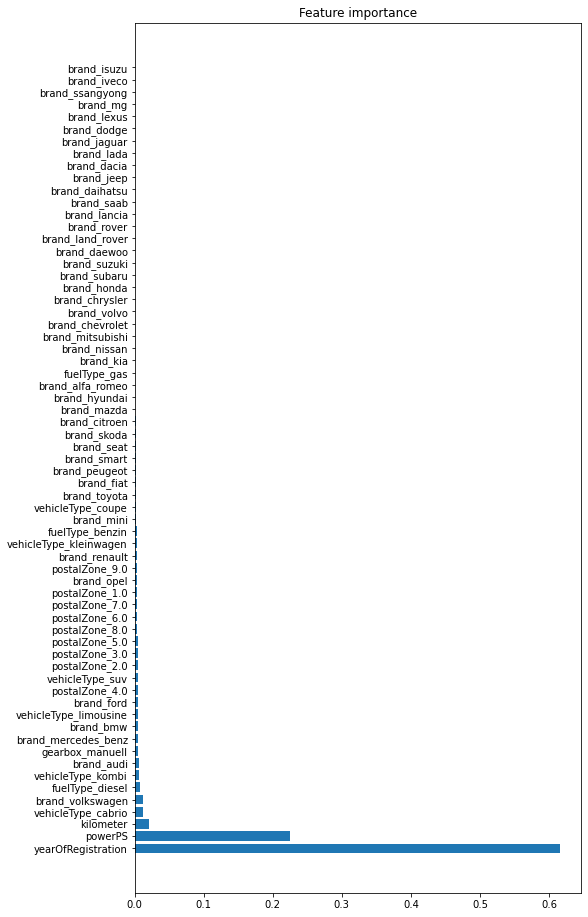

In [23]:
print('Importancia de los atributos en el modelo DecisionTreeRegressor entrenado con datos con imputación de valores perdidos')
plt.figure(figsize=(8,16))
aux.plot_importance(pickle.load(open('DecisionTreeRegressor_it1_imp.pkl', 'rb')), X_mat_imp.columns)

- Observamos como el modelo DecisionTreeRegresor consideró como característica más importante `yearOfRegistration` seguidas por `powerPS` y `kilometer`. 
- La gran mayoría de marcas apenas fueron consideradas en la reducción del error a la hora de particionar nodos

#### Random Forest Regressor

Importancia de los atributos en el modelo RandomForestRegressor entrenado con datos con imputación de valores perdidos


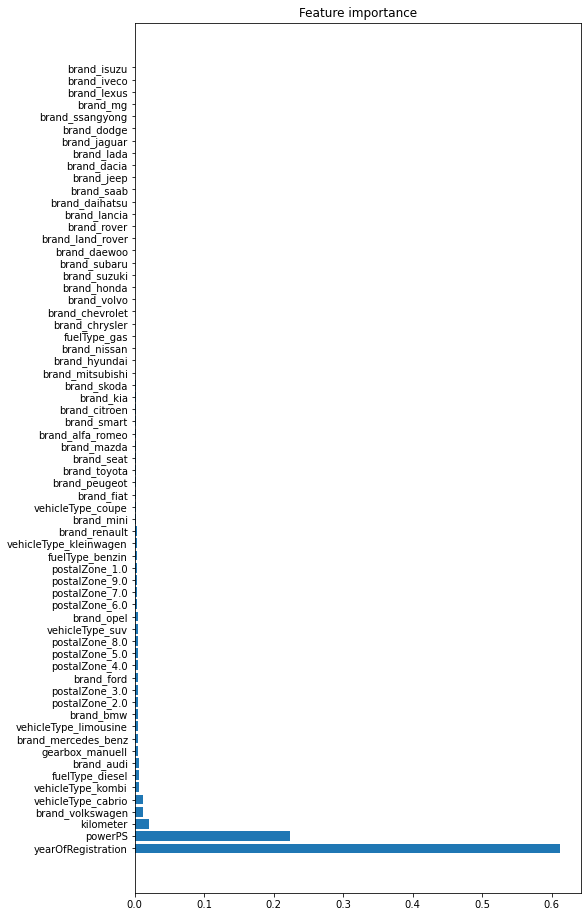

In [24]:
print('Importancia de los atributos en el modelo RandomForestRegressor entrenado con datos con imputación de valores perdidos')
plt.figure(figsize=(8,16))
aux.plot_importance(pickle.load(open('RandomForestRegressor_it1_imp.pkl', 'rb')), X_mat_imp.columns)

- Llama la atención que no se haya suavizado la importancia de las diferentes variables respecto al modelo de árbol de decisión, teniendo en cuenta que RandomForest entrena por defecto 100 árboles diferentes haciendo la primera partición en cada árbol de decisión individual  mediante el método de bootstrap aggregating (bagging), esto es, utilizando subconjuntos diferentes de datos.

#### XGBoost Regressor

Importancia de los atributos en el modelo GradientBoostingRegressor entrenado con datos con imputación de valores perdidos


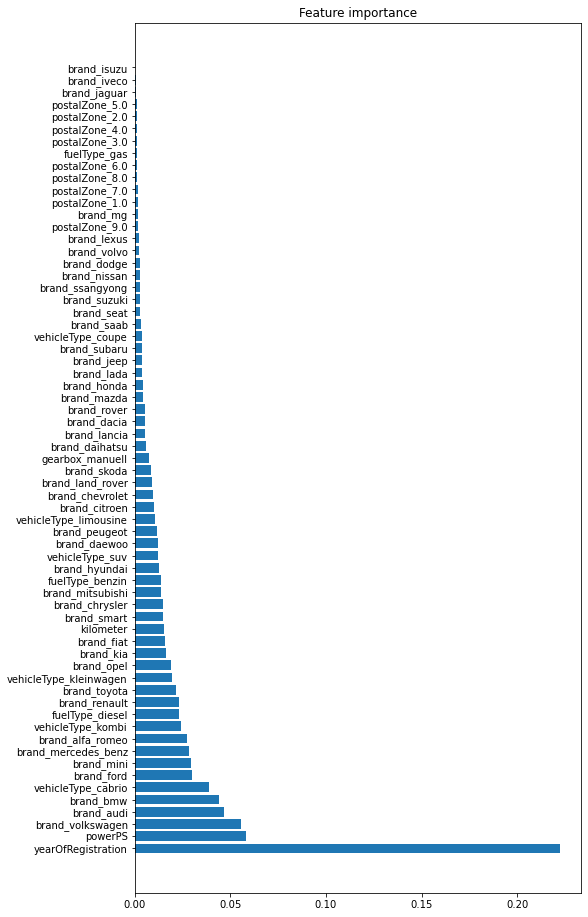

In [25]:
print('Importancia de los atributos en el modelo XGBRegressor entrenado con datos con imputación de valores perdidos')
plt.figure(figsize=(8,16))
aux.plot_importance(pickle.load(open('XGBRegressor_it1_imp.pkl', 'rb')), X_mat_imp.columns)

- En este caso encontramos un reparto más equitativo de las importancias.
- Posiblemente esto se deba a que XGBoost puede repartir más equitativamente las importancias por su naturaleza secuencial y enfoque basado en gradientes y optimización. Estas características le permiten adaptarse mejor a la relevancia de las características en función de la complejidad y los patrones del conjunto de datos, lo que puede resultar en una distribución más balanceada de las importancias en comparación con Random Forest.

## Elección del mejor modelo y serialización
- Por un lado, tenemos la sencillez de interpretación, rápida implementación y capacaidad de generalización del modelo de regresión lineal. La relación lineal de las variables continuas hacen que este modelo se adecúe correctamente al problema.
- Por otro lado, tenemos los modelos basados en árboles de decisión de los cuales destacamos XGBRegressor. A pesar de tener métricas muy similares a Random Forest su reparto más equilibrado de las importancias puede ser más positivo a la hora de capturar el fenómeno.
- Entre estos dos, pensamos que el modelo de Regresión Lineal, a pesar de tener unas métricas ligeramente inferiores (MAPE de 0.36 vs 0.31) puede adaptarse mejor al problema por su naturaleza lineal y conseguir una mejor generalización al enfrentar datos diferentes a los que utilizamos para entrenar. También permite hacer predicciones con cifras de kilometraje superiores a 150.000 kilómetros no vistas durante el entrenamiento al aplicar los coeficientes, mientras que XGBRegressor es incapaz de ello.


Seleccionamos el mejor modelo junto con su instancia de StandardScaler y los nombres de las columnas codificadas y lo exportamos para la puesta en producción


In [ ]:
# Ya exportado
best_model = 'LinearRegression_it1_imp.pkl'

In [ ]:
# Serializamos el preprocesamiento correspondiente al modelo ganador
pickle.dump(scaler_imp, open("scaler_imp.pkl", 'wb'))

In [ ]:
# Serializamos la data codificada (binary encoding)
X_test_std_imp.drop(index=X_test_std_imp.index).to_csv('columns_encoded.csv', index=False)